# NLP Apps I - Final Project

# Automatic Detection of Stance Against Vaccines

## Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Installing the required libraries

In [ ]:
!pip install -U spacy==2.3.7
!python -m spacy download es_core_news_sm
!pip install flair
!pip install transformers datasets evaluate
!pip install mlxtend==0.17.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.4 MB/s eta 0:00:00
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.1
    Uninstalling wasabi-1.1.1:
      Successfully uninstalled wasabi-1.1.1
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.6
    Uninstalling srsly-2.4.6:
      Successfully uninstalled srsly-2.4.6
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.8
    Uninstalling catalogue-2.0.8:
      Successfully uninstalled catalogue-2.0.8
  Attempting uninstall: thinc
    Found existing installation: thinc 8.1.9
    Uninstalling thinc-8.1.9:
      Successfully uninstalled thinc-8.1.9
  Attempting uninstall: spacy
    Found existing

## Import the required libraries

In [ ]:
import os
import re
import pandas as pd
import spacy
import es_core_news_sm
from sklearn.metrics import classification_report, confusion_matrix
import random
import time
import numpy as np

from spacy.util import minibatch, compounding

from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from flair.embeddings import WordEmbeddings, DocumentRNNEmbeddings, FlairEmbeddings

from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate
import numpy as np
from huggingface_hub import notebook_login

from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

## Pre-processing

In [ ]:
DRIVE_PATH = "/content/drive/MyDrive/APP I- FINAL PROJECT/"
DATA_PATH = os.path.join(DRIVE_PATH, "Data")

train_csv_path = os.path.join(DATA_PATH, "es_train.csv")
test_csv_path = os.path.join(DATA_PATH, "es_test.csv")
preprocessed_train_csv_file = os.path.join(DATA_PATH, "pre_processed_train.csv")
preprocessed_test_csv_file = os.path.join(DATA_PATH, "pre_processed_test.csv")

def load_csv(file_name):
  df = pd.read_csv(file_name)
  if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])
  return df


def print_statistics(df, preprocessed=False):
  print("Label counts")
  print(df['label'].value_counts())

  text_coln = 'preprocessed_text' if preprocessed else 'text'

  len_of_texts = [len(text) for text in df[text_coln]]
  max_len = max(len_of_texts)
  min_len = min(len_of_texts)
  avg_len = sum(len_of_texts) / len(len_of_texts)

  print(f"Sentence Lengths: Max: {max_len} | Min: {min_len} | Avg: {avg_len}")


def remove_mentions_links(text):
  return re.sub(r"(?:\@|https?\://)\S+", "", text)

def lemmatize(text, nlp):
  doc = nlp(text)
  new_text = [token.lemma_ for token in doc]
  return " ".join(new_text)

def preprocess(text, nlp):
  formatted_text = remove_mentions_links(text)
  return lemmatize(formatted_text, nlp)

### Applying functions to get statistics and storing pre-processing data

In [ ]:
train_df = load_csv(train_csv_path)
test_df = load_csv(test_csv_path)

print("Statistics of the training data before pre-processing:")
print_statistics(train_df)
print("\n")

nlp = es_core_news_sm.load()
train_df["preprocessed_text"] = train_df['text'].apply(preprocess, args=(nlp,))
test_df["preprocessed_text"] = test_df['text'].apply(preprocess, args=(nlp,))

print("Statistics of the training data after pre-processing:")
print_statistics(train_df, preprocessed=True)
print("\n")


train_df.to_csv(preprocessed_train_csv_file)
test_df.to_csv(preprocessed_test_csv_file)

Statistics of the training data before pre-processing:
Label counts
FAVOR      937
NONE       591
AGAINST    475
Name: label, dtype: int64
Sentence Lengths: Max: 525 | Min: 11 | Avg: 139.94857713429855


Statistics of the training data after pre-processing:
Label counts
FAVOR      937
NONE       591
AGAINST    475
Name: label, dtype: int64
Sentence Lengths: Max: 311 | Min: 9 | Avg: 124.08537194208687




## Baseline Spacy Classifier - CBOW/Simple CNN

### Loading data into spacy format

In [ ]:
def load_data_spacy(file_name):
  data = load_csv(file_name)

  texts = data['preprocessed_text'].tolist()
  categories = data['label'].to_list()
  final_categories = [{
      "AGAINST": 0,
      "FAVOR": 0,
      "NONE": 0
  } for i in range(len(categories))]

  for cat, label in zip(final_categories, categories):
    cat[label] = 1
    
  final_data = list(zip(texts, [{"cats": cats} for cats in final_categories]))
  return final_data, texts, categories


### Defining functions for evaluation

In [ ]:
def reverse_sort_by_scores(sub_list):
  # reverse = True (Soresulting_list = list(first_list)rts in Descending  order) 
  # key is set to sort using second element of  
  # sublist lambda has been used 
  return(sorted(sub_list, key = lambda x: x[1],reverse=True))  

# run the predictions on each sentence in the evaluation  dataset, and return the metrics
def evaluate(tokenizer, textcat, test_texts, test_cats):
  docs = (tokenizer(text) for text in test_texts)
  preds = []
  for i, doc in enumerate(textcat.pipe(docs)):
    scores = reverse_sort_by_scores(doc.cats.items())
    preds.append(scores[0][0])
        
  labels = ['AGAINST', 'FAVOR', 'NONE']
  print(classification_report(test_cats, preds,labels=labels))
    

### Defining function for training

In [ ]:
def train_spacy(  train_data, iterations,test_texts,test_cats, model_arch, dropout = 0.3, model=None, init_tok2vec=None):
    ''' Train a spacy model, which can be queried against with test data
   
    train_data : training data in the format of (sentence, {cats: ['AGAINST'|'FAVOR'|'NONE']})
    labels : a list of unique annotations
    iterations : number of training iterations
    dropout : dropout proportion for training
    display_freq : number of epochs between logging losses to console
    '''
    
    nlp = es_core_news_sm.load()
    
    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "textcat" not in nlp.pipe_names:
        textcat = nlp.create_pipe(
            "textcat", config={"exclusive_classes": True, "architecture": model_arch}
        )
        nlp.add_pipe(textcat, last=True)
        
    # otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe("textcat")

    # add label to text classifier
    textcat.add_label("AGAINST")
    textcat.add_label("FAVOR")
    textcat.add_label("NONE")

    # get names of other pipes to disable them during training
    pipe_exceptions = ["textcat", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        if init_tok2vec is not None:
            with init_tok2vec.open("rb") as file_:
                textcat.model.tok2vec.from_bytes(file_.read())
        batch_sizes = compounding(16.0, 64.0, 1.5)
        for i in range(iterations):
            start_time = time.time()
            losses = {}
            # batch up the examples using spaCy's minibatch
            random.shuffle(train_data)
            batches = minibatch(train_data, size=batch_sizes)
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=dropout, losses=losses)
        
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the test data 
            evaluate(nlp.tokenizer, textcat, test_texts,test_cats)
        with nlp.use_params(optimizer.averages):
            model_name = model_arch + "_fake_news"
            filepath = DRIVE_PATH + model_name 
            nlp.to_disk(filepath)
    return nlp

### Loading data into spacy format

In [ ]:
def load_data_spacy(file_name):
  data = load_csv(file_name)

  texts = data['preprocessed_text'].tolist()
  categories = data['label'].to_list()
  final_categories = [{
      "AGAINST": 0,
      "FAVOR": 0,
      "NONE": 0
  } for i in range(len(categories))]

  for cat, label in zip(final_categories, categories):
    cat[label] = 1
    
  final_data = list(zip(texts, [{"cats": cats} for cats in final_categories]))
  return final_data, texts, categories


### Defining functions for evaluation

In [ ]:
def reverse_sort_by_scores(sub_list):
  # reverse = True (Soresulting_list = list(first_list)rts in Descending  order) 
  # key is set to sort using second element of  
  # sublist lambda has been used 
  return(sorted(sub_list, key = lambda x: x[1],reverse=True))  

# run the predictions on each sentence in the evaluation  dataset, and return the metrics
def evaluate(tokenizer, textcat, test_texts, test_cats):
  docs = (tokenizer(text) for text in test_texts)
  preds = []
  for i, doc in enumerate(textcat.pipe(docs)):
    scores = reverse_sort_by_scores(doc.cats.items())
    preds.append(scores[0][0])
        
  labels = ['AGAINST', 'FAVOR', 'NONE']
  print(classification_report(test_cats, preds,labels=labels))
    

### Defining function for training

In [ ]:
def train_spacy(  train_data, iterations,test_texts,test_cats, model_arch, dropout = 0.3, model=None, init_tok2vec=None):
    ''' Train a spacy model, which can be queried against with test data
   
    train_data : training data in the format of (sentence, {cats: ['AGAINST'|'FAVOR'|'NONE']})
    labels : a list of unique annotations
    iterations : number of training iterations
    dropout : dropout proportion for training
    display_freq : number of epochs between logging losses to console
    '''
    
    nlp = es_core_news_sm.load()
    
    # add the text classifier to the pipeline if it doesn't exist
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "textcat" not in nlp.pipe_names:
        textcat = nlp.create_pipe(
            "textcat", config={"exclusive_classes": True, "architecture": model_arch}
        )
        nlp.add_pipe(textcat, last=True)
        
    # otherwise, get it, so we can add labels to it
    else:
        textcat = nlp.get_pipe("textcat")

    # add label to text classifier
    textcat.add_label("AGAINST")
    textcat.add_label("FAVOR")
    textcat.add_label("NONE")

    # get names of other pipes to disable them during training
    pipe_exceptions = ["textcat", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    with nlp.disable_pipes(*other_pipes):  # only train textcat
        optimizer = nlp.begin_training()
        if init_tok2vec is not None:
            with init_tok2vec.open("rb") as file_:
                textcat.model.tok2vec.from_bytes(file_.read())
        batch_sizes = compounding(16.0, 64.0, 1.5)
        for i in range(iterations):
            start_time = time.time()
            losses = {}
            # batch up the examples using spaCy's minibatch
            random.shuffle(train_data)
            batches = minibatch(train_data, size=batch_sizes)
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, sgd=optimizer, drop=dropout, losses=losses)
        
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the test data 
            evaluate(nlp.tokenizer, textcat, test_texts,test_cats)
        with nlp.use_params(optimizer.averages):
            model_name = model_arch + "_fake_news"
            filepath = DRIVE_PATH + model_name 
            nlp.to_disk(filepath)
    return nlp

### BOW Model

In [ ]:
train_data, train_texts, train_cats = load_data_spacy(preprocessed_train_csv_file)
test_data, test_texts, test_cats = load_data_spacy(preprocessed_test_csv_file)

nlp = train_spacy(train_data, 20, test_texts, test_cats, "bow")

              precision    recall  f1-score   support

     AGAINST       0.82      0.59      0.68       140
       FAVOR       0.77      0.87      0.82       359
        NONE       0.73      0.72      0.73       195

    accuracy                           0.77       694
   macro avg       0.78      0.73      0.74       694
weighted avg       0.77      0.77      0.77       694



### Simple CNN

In [ ]:
train_data, train_texts, train_cats = load_data_spacy(preprocessed_train_csv_file)
test_data, test_texts, test_cats = load_data_spacy(preprocessed_test_csv_file)

nlp = train_spacy(train_data, 20, test_texts, test_cats, "simple_cnn")

              precision    recall  f1-score   support

     AGAINST       0.64      0.62      0.63       140
       FAVOR       0.76      0.78      0.77       359
        NONE       0.69      0.68      0.68       195

    accuracy                           0.72       694
   macro avg       0.70      0.69      0.70       694
weighted avg       0.72      0.72      0.72       694



## Flair Models

### Loading the data into Flair Corpus

In [ ]:
# this is the folder in which train, test and dev files reside
data_folder = '/content/drive/MyDrive/APP I- FINAL PROJECT/Data_flair'

# column format indicating which columns hold the text and label(s)
column_name_map = {0: 'label', 1: 'text'}

# load corpus containing training, test and dev data and if CSV has a header, you can skip it
corpus: Corpus = CSVClassificationCorpus(data_folder,
                                         column_name_map,
                                         skip_header=True,
                                         delimiter=',',    # tab-separated files
                                         label_type='label',
)

2023-04-17 13:34:07,013 Reading data from /content/drive/MyDrive/APP I- FINAL PROJECT/Data_flair
2023-04-17 13:34:07,018 Train: /content/drive/MyDrive/APP I- FINAL PROJECT/Data_flair/train.csv
2023-04-17 13:34:07,023 Dev: /content/drive/MyDrive/APP I- FINAL PROJECT/Data_flair/dev.csv
2023-04-17 13:34:07,024 Test: /content/drive/MyDrive/APP I- FINAL PROJECT/Data_flair/test.csv


### Defining the glove and flair embeddings

In [ ]:
word_embeddings = [WordEmbeddings('es')]
embeddings_glove = DocumentRNNEmbeddings(word_embeddings, hidden_size=512)

embeddings_flair = [FlairEmbeddings('es-forward-fast')]
embeddings_flair = DocumentRNNEmbeddings(embeddings_flair, hidden_size=512) 

2023-04-17 13:34:10,636 https://flair.informatik.hu-berlin.de/resources/embeddings/token/es-wiki-fasttext-300d-1M.vectors.npy not found in cache, downloading to /tmp/tmp9lsoyxvz


100%|██████████| 1.10G/1.10G [01:14<00:00, 15.9MB/s]

2023-04-17 13:35:25,301 copying /tmp/tmp9lsoyxvz to cache at /root/.flair/embeddings/es-wiki-fasttext-300d-1M.vectors.npy


2023-04-17 13:35:29,790 removing temp file /tmp/tmp9lsoyxvz
2023-04-17 13:35:30,642 https://flair.informatik.hu-berlin.de/resources/embeddings/token/es-wiki-fasttext-300d-1M not found in cache, downloading to /tmp/tmphkiz3uo9


100%|██████████| 37.8M/37.8M [00:02<00:00, 17.5MB/s]

2023-04-17 13:35:33,292 copying /tmp/tmphkiz3uo9 to cache at /root/.flair/embeddings/es-wiki-fasttext-300d-1M
2023-04-17 13:35:33,348 removing temp file /tmp/tmphkiz3uo9


2023-04-17 13:35:51,992 https://flair.informatik.hu-berlin.de/resources/embeddings/flair/lm-es-forward-fast.pt not found in cache, downloading to /tmp/tmp6f85s409


100%|██████████| 18.8M/18.8M [00:01<00:00, 12.2MB/s]

2023-04-17 13:35:53,977 copying /tmp/tmp6f85s409 to cache at /root/.flair/embeddings/lm-es-forward-fast.pt
2023-04-17 13:35:53,999 removing temp file /tmp/tmp6f85s409


### Build the label dictionary

In [ ]:
label_type = 'label'

label_dict = corpus.make_label_dictionary(label_type=label_type)
print(label_dict)

2023-04-17 13:37:03,461 Computing label dictionary. Progress:


1602it [00:00, 2439.52it/s]

2023-04-17 13:37:04,138 Dictionary created for label 'label' with 4 values: FAVOR (seen 754 times), NONE (seen 472 times), AGAINST (seen 376 times)
Dictionary with 4 tags: <unk>, FAVOR, NONE, AGAINST


### Train the Classifier with Glove Embeddings - Static Embeddings

In [ ]:
classifier_glove = TextClassifier(embeddings_glove, label_dictionary= label_dict, label_type=label_type, multi_label=False)

# Define trainer and start training: Glove embeddings
trainer_glove = ModelTrainer(classifier_glove, corpus)
trainer_glove.train('/content/drive/MyDrive/APP I- FINAL PROJECT/flair_glove', max_epochs=20)



/usr/local/lib/python3.9/dist-packages/flair/trainers/trainer.py:69: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2023-04-17 13:37:08,398 ----------------------------------------------------------------------------------------------------
2023-04-17 13:37:08,404 Model: "TextClassifier(
  (embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings(
        'es'
        (embedding): Embedding(985667, 300)
      )
    )
    (word_reprojection_map): Linear(in_features=300, out_features=300, bias=True)
    (rnn): GRU(300, 512, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (weights): None
  (weight_tensor) None
)"
2023-04-17 13:37:08,410 ----------------------------------------------------------------------------------------------------
2023-04-17 13:37:08,413 Corpus: "Corpus: 1602 train + 401 dev + 694 test

100%|██████████| 13/13 [00:01<00:00, 10.62it/s]


2023-04-17 13:37:31,935 Evaluating as a multi-label problem: False
2023-04-17 13:37:31,956 DEV : loss 1.0640285015106201 - f1-score (micro avg)  0.4763
2023-04-17 13:37:32,671 BAD EPOCHS (no improvement): 0
2023-04-17 13:37:32,680 saving best model
2023-04-17 13:37:38,953 ----------------------------------------------------------------------------------------------------
2023-04-17 13:37:41,275 epoch 2 - iter 5/51 - loss 0.98920250 - time (sec): 2.32 - samples/sec: 69.05 - lr: 0.100000
2023-04-17 13:37:43,793 epoch 2 - iter 10/51 - loss 1.02626280 - time (sec): 4.83 - samples/sec: 66.19 - lr: 0.100000
2023-04-17 13:37:46,606 epoch 2 - iter 15/51 - loss 1.02166389 - time (sec): 7.65 - samples/sec: 62.76 - lr: 0.100000
2023-04-17 13:37:49,097 epoch 2 - iter 20/51 - loss 1.02787160 - time (sec): 10.14 - samples/sec: 63.12 - lr: 0.100000
2023-04-17 13:37:51,731 epoch 2 - iter 25/51 - loss 1.02453809 - time (sec): 12.77 - samples/sec: 62.64 - lr: 0.100000
2023-04-17 13:37:54,162 epoch 2 - i

100%|██████████| 13/13 [00:01<00:00,  7.11it/s]

2023-04-17 13:38:08,669 Evaluating as a multi-label problem: False
2023-04-17 13:38:08,688 DEV : loss 1.021750569343567 - f1-score (micro avg)  0.5187


2023-04-17 13:38:08,868 BAD EPOCHS (no improvement): 0
2023-04-17 13:38:08,887 saving best model
2023-04-17 13:38:15,424 ----------------------------------------------------------------------------------------------------
2023-04-17 13:38:17,774 epoch 3 - iter 5/51 - loss 0.86026220 - time (sec): 2.34 - samples/sec: 68.42 - lr: 0.100000
2023-04-17 13:38:20,458 epoch 3 - iter 10/51 - loss 0.90370324 - time (sec): 5.02 - samples/sec: 63.71 - lr: 0.100000
2023-04-17 13:38:25,039 epoch 3 - iter 15/51 - loss 0.91046371 - time (sec): 9.60 - samples/sec: 49.98 - lr: 0.100000
2023-04-17 13:38:28,361 epoch 3 - iter 20/51 - loss 0.91620291 - time (sec): 12.93 - samples/sec: 49.51 - lr: 0.100000
2023-04-17 13:38:31,138 epoch 3 - iter 25/51 - loss 0.92873095 - time (sec): 15.70 - samples/sec: 50.95 - lr: 0.100000
2023-04-17 13:38:33,747 epoch 3 - iter 30/51 - loss 0.94191783 - time (sec): 18.31 - samples/sec: 52.43 - lr: 0.100000
2023-04-17 13:38:35,655 epoch 3 - iter 35/51 - loss 0.95058779 - tim

100%|██████████| 13/13 [00:01<00:00,  9.53it/s]

2023-04-17 13:38:45,260 Evaluating as a multi-label problem: False
2023-04-17 13:38:45,280 DEV : loss 1.282086968421936 - f1-score (micro avg)  0.409


2023-04-17 13:38:45,449 BAD EPOCHS (no improvement): 1
2023-04-17 13:38:45,458 ----------------------------------------------------------------------------------------------------
2023-04-17 13:38:47,499 epoch 4 - iter 5/51 - loss 1.00728989 - time (sec): 2.04 - samples/sec: 78.60 - lr: 0.100000
2023-04-17 13:38:49,438 epoch 4 - iter 10/51 - loss 0.91114082 - time (sec): 3.97 - samples/sec: 80.51 - lr: 0.100000
2023-04-17 13:38:51,174 epoch 4 - iter 15/51 - loss 0.91794691 - time (sec): 5.71 - samples/sec: 84.05 - lr: 0.100000
2023-04-17 13:38:52,947 epoch 4 - iter 20/51 - loss 0.93434839 - time (sec): 7.48 - samples/sec: 85.52 - lr: 0.100000
2023-04-17 13:38:55,208 epoch 4 - iter 25/51 - loss 0.92906537 - time (sec): 9.74 - samples/sec: 82.10 - lr: 0.100000
2023-04-17 13:38:57,975 epoch 4 - iter 30/51 - loss 0.91871524 - time (sec): 12.51 - samples/sec: 76.73 - lr: 0.100000
2023-04-17 13:39:01,455 epoch 4 - iter 35/51 - loss 0.92000041 - time (sec): 15.99 - samples/sec: 70.04 - lr: 0.

100%|██████████| 13/13 [00:01<00:00,  7.77it/s]

2023-04-17 13:39:09,052 Evaluating as a multi-label problem: False


2023-04-17 13:39:09,126 DEV : loss 1.2327827215194702 - f1-score (micro avg)  0.5187
2023-04-17 13:39:09,553 BAD EPOCHS (no improvement): 2
2023-04-17 13:39:09,564 ----------------------------------------------------------------------------------------------------
2023-04-17 13:39:13,977 epoch 5 - iter 5/51 - loss 0.99999959 - time (sec): 4.41 - samples/sec: 36.28 - lr: 0.100000
2023-04-17 13:39:16,709 epoch 5 - iter 10/51 - loss 0.98140429 - time (sec): 7.14 - samples/sec: 44.81 - lr: 0.100000
2023-04-17 13:39:19,288 epoch 5 - iter 15/51 - loss 0.92098765 - time (sec): 9.72 - samples/sec: 49.38 - lr: 0.100000
2023-04-17 13:39:22,034 epoch 5 - iter 20/51 - loss 0.91253166 - time (sec): 12.47 - samples/sec: 51.34 - lr: 0.100000
2023-04-17 13:39:24,777 epoch 5 - iter 25/51 - loss 0.90778456 - time (sec): 15.21 - samples/sec: 52.60 - lr: 0.100000
2023-04-17 13:39:26,548 epoch 5 - iter 30/51 - loss 0.90181585 - time (sec): 16.98 - samples/sec: 56.54 - lr: 0.100000
2023-04-17 13:39:28,421 e

100%|██████████| 13/13 [00:01<00:00,  6.56it/s]

2023-04-17 13:39:36,948 Evaluating as a multi-label problem: False
2023-04-17 13:39:36,977 DEV : loss 1.014525055885315 - f1-score (micro avg)  0.5436


2023-04-17 13:39:37,296 BAD EPOCHS (no improvement): 0
2023-04-17 13:39:37,308 saving best model
2023-04-17 13:39:46,101 ----------------------------------------------------------------------------------------------------
2023-04-17 13:39:48,196 epoch 6 - iter 5/51 - loss 0.77645800 - time (sec): 2.09 - samples/sec: 76.65 - lr: 0.100000
2023-04-17 13:39:50,855 epoch 6 - iter 10/51 - loss 0.88064461 - time (sec): 4.75 - samples/sec: 67.41 - lr: 0.100000
2023-04-17 13:39:53,627 epoch 6 - iter 15/51 - loss 0.91587707 - time (sec): 7.52 - samples/sec: 63.85 - lr: 0.100000
2023-04-17 13:39:58,151 epoch 6 - iter 20/51 - loss 0.90629685 - time (sec): 12.04 - samples/sec: 53.14 - lr: 0.100000
2023-04-17 13:40:01,387 epoch 6 - iter 25/51 - loss 0.91290571 - time (sec): 15.28 - samples/sec: 52.36 - lr: 0.100000
2023-04-17 13:40:03,715 epoch 6 - iter 30/51 - loss 0.90379263 - time (sec): 17.61 - samples/sec: 54.52 - lr: 0.100000
2023-04-17 13:40:06,037 epoch 6 - iter 35/51 - loss 0.90013217 - tim

100%|██████████| 13/13 [00:01<00:00,  6.52it/s]

2023-04-17 13:40:14,825 Evaluating as a multi-label problem: False
2023-04-17 13:40:14,853 DEV : loss 0.8939298987388611 - f1-score (micro avg)  0.5536


2023-04-17 13:40:15,883 BAD EPOCHS (no improvement): 0
2023-04-17 13:40:15,893 saving best model
2023-04-17 13:40:22,890 ----------------------------------------------------------------------------------------------------
2023-04-17 13:40:24,875 epoch 7 - iter 5/51 - loss 0.86611511 - time (sec): 1.96 - samples/sec: 81.71 - lr: 0.100000
2023-04-17 13:40:26,767 epoch 7 - iter 10/51 - loss 0.84573748 - time (sec): 3.85 - samples/sec: 83.13 - lr: 0.100000
2023-04-17 13:40:29,520 epoch 7 - iter 15/51 - loss 0.82596273 - time (sec): 6.60 - samples/sec: 72.70 - lr: 0.100000
2023-04-17 13:40:34,138 epoch 7 - iter 20/51 - loss 0.82293821 - time (sec): 11.22 - samples/sec: 57.04 - lr: 0.100000
2023-04-17 13:40:37,882 epoch 7 - iter 25/51 - loss 0.84495413 - time (sec): 14.96 - samples/sec: 53.46 - lr: 0.100000
2023-04-17 13:40:40,296 epoch 7 - iter 30/51 - loss 0.87372908 - time (sec): 17.38 - samples/sec: 55.24 - lr: 0.100000
2023-04-17 13:40:42,706 epoch 7 - iter 35/51 - loss 0.88806283 - tim

100%|██████████| 13/13 [00:02<00:00,  4.67it/s]

2023-04-17 13:40:52,576 Evaluating as a multi-label problem: False
2023-04-17 13:40:52,603 DEV : loss 0.9157344698905945 - f1-score (micro avg)  0.5786


2023-04-17 13:40:52,913 BAD EPOCHS (no improvement): 0
2023-04-17 13:40:52,925 saving best model
2023-04-17 13:41:00,110 ----------------------------------------------------------------------------------------------------
2023-04-17 13:41:02,099 epoch 8 - iter 5/51 - loss 0.82029856 - time (sec): 1.98 - samples/sec: 80.81 - lr: 0.100000
2023-04-17 13:41:03,956 epoch 8 - iter 10/51 - loss 0.85923370 - time (sec): 3.84 - samples/sec: 83.41 - lr: 0.100000
2023-04-17 13:41:06,422 epoch 8 - iter 15/51 - loss 0.84196375 - time (sec): 6.30 - samples/sec: 76.15 - lr: 0.100000
2023-04-17 13:41:09,879 epoch 8 - iter 20/51 - loss 0.84631967 - time (sec): 9.76 - samples/sec: 65.58 - lr: 0.100000
2023-04-17 13:41:14,264 epoch 8 - iter 25/51 - loss 0.84782507 - time (sec): 14.14 - samples/sec: 56.56 - lr: 0.100000
2023-04-17 13:41:17,124 epoch 8 - iter 30/51 - loss 0.84439494 - time (sec): 17.00 - samples/sec: 56.46 - lr: 0.100000
2023-04-17 13:41:19,699 epoch 8 - iter 35/51 - loss 0.85574526 - time

100%|██████████| 13/13 [00:01<00:00,  6.55it/s]

2023-04-17 13:41:30,108 Evaluating as a multi-label problem: False
2023-04-17 13:41:30,134 DEV : loss 0.8932505249977112 - f1-score (micro avg)  0.5935


2023-04-17 13:41:30,439 BAD EPOCHS (no improvement): 0
2023-04-17 13:41:30,447 saving best model
2023-04-17 13:41:37,896 ----------------------------------------------------------------------------------------------------
2023-04-17 13:41:40,019 epoch 9 - iter 5/51 - loss 0.86376770 - time (sec): 2.10 - samples/sec: 76.10 - lr: 0.100000
2023-04-17 13:41:41,987 epoch 9 - iter 10/51 - loss 0.85068392 - time (sec): 4.07 - samples/sec: 78.61 - lr: 0.100000
2023-04-17 13:41:45,332 epoch 9 - iter 15/51 - loss 0.88036424 - time (sec): 7.42 - samples/sec: 64.72 - lr: 0.100000
2023-04-17 13:41:49,862 epoch 9 - iter 20/51 - loss 0.86353891 - time (sec): 11.95 - samples/sec: 53.58 - lr: 0.100000
2023-04-17 13:41:53,224 epoch 9 - iter 25/51 - loss 0.85950691 - time (sec): 15.31 - samples/sec: 52.26 - lr: 0.100000
2023-04-17 13:41:55,429 epoch 9 - iter 30/51 - loss 0.85768087 - time (sec): 17.51 - samples/sec: 54.82 - lr: 0.100000
2023-04-17 13:41:58,543 epoch 9 - iter 35/51 - loss 0.84721201 - tim

100%|██████████| 13/13 [00:02<00:00,  6.49it/s]

2023-04-17 13:42:07,775 Evaluating as a multi-label problem: False
2023-04-17 13:42:07,807 DEV : loss 0.8970133066177368 - f1-score (micro avg)  0.5985


2023-04-17 13:42:08,115 BAD EPOCHS (no improvement): 0
2023-04-17 13:42:08,126 saving best model
2023-04-17 13:42:15,496 ----------------------------------------------------------------------------------------------------
2023-04-17 13:42:17,528 epoch 10 - iter 5/51 - loss 0.83460102 - time (sec): 2.03 - samples/sec: 78.99 - lr: 0.100000
2023-04-17 13:42:19,360 epoch 10 - iter 10/51 - loss 0.85268580 - time (sec): 3.86 - samples/sec: 82.95 - lr: 0.100000
2023-04-17 13:42:21,790 epoch 10 - iter 15/51 - loss 0.84627918 - time (sec): 6.29 - samples/sec: 76.34 - lr: 0.100000
2023-04-17 13:42:25,634 epoch 10 - iter 20/51 - loss 0.83114369 - time (sec): 10.13 - samples/sec: 63.17 - lr: 0.100000
2023-04-17 13:42:30,180 epoch 10 - iter 25/51 - loss 0.82185281 - time (sec): 14.68 - samples/sec: 54.50 - lr: 0.100000
2023-04-17 13:42:32,783 epoch 10 - iter 30/51 - loss 0.82551313 - time (sec): 17.28 - samples/sec: 55.56 - lr: 0.100000
2023-04-17 13:42:35,415 epoch 10 - iter 35/51 - loss 0.8268392

100%|██████████| 13/13 [00:01<00:00,  6.52it/s]

2023-04-17 13:42:44,937 Evaluating as a multi-label problem: False
2023-04-17 13:42:44,963 DEV : loss 0.9501874446868896 - f1-score (micro avg)  0.5287


2023-04-17 13:42:45,257 BAD EPOCHS (no improvement): 1
2023-04-17 13:42:45,266 ----------------------------------------------------------------------------------------------------
2023-04-17 13:42:47,798 epoch 11 - iter 5/51 - loss 0.79430546 - time (sec): 2.53 - samples/sec: 63.30 - lr: 0.100000
2023-04-17 13:42:50,360 epoch 11 - iter 10/51 - loss 0.81576216 - time (sec): 5.09 - samples/sec: 62.88 - lr: 0.100000
2023-04-17 13:42:52,325 epoch 11 - iter 15/51 - loss 0.80450034 - time (sec): 7.05 - samples/sec: 68.04 - lr: 0.100000
2023-04-17 13:42:54,194 epoch 11 - iter 20/51 - loss 0.79540184 - time (sec): 8.92 - samples/sec: 71.72 - lr: 0.100000
2023-04-17 13:42:56,037 epoch 11 - iter 25/51 - loss 0.81560838 - time (sec): 10.77 - samples/sec: 74.31 - lr: 0.100000
2023-04-17 13:42:58,272 epoch 11 - iter 30/51 - loss 0.84166600 - time (sec): 13.00 - samples/sec: 73.84 - lr: 0.100000
2023-04-17 13:43:00,868 epoch 11 - iter 35/51 - loss 0.84227842 - time (sec): 15.60 - samples/sec: 71.81 

100%|██████████| 13/13 [00:01<00:00, 10.77it/s]

2023-04-17 13:43:09,343 Evaluating as a multi-label problem: False
2023-04-17 13:43:09,362 DEV : loss 2.9717624187469482 - f1-score (micro avg)  0.3915


2023-04-17 13:43:10,107 BAD EPOCHS (no improvement): 2
2023-04-17 13:43:10,114 ----------------------------------------------------------------------------------------------------
2023-04-17 13:43:11,967 epoch 12 - iter 5/51 - loss 1.06344681 - time (sec): 1.85 - samples/sec: 86.48 - lr: 0.100000
2023-04-17 13:43:13,705 epoch 12 - iter 10/51 - loss 0.96049628 - time (sec): 3.59 - samples/sec: 89.18 - lr: 0.100000
2023-04-17 13:43:15,608 epoch 12 - iter 15/51 - loss 0.86980570 - time (sec): 5.49 - samples/sec: 87.42 - lr: 0.100000
2023-04-17 13:43:18,308 epoch 12 - iter 20/51 - loss 0.84178442 - time (sec): 8.19 - samples/sec: 78.14 - lr: 0.100000
2023-04-17 13:43:21,174 epoch 12 - iter 25/51 - loss 0.84420294 - time (sec): 11.06 - samples/sec: 72.35 - lr: 0.100000
2023-04-17 13:43:23,866 epoch 12 - iter 30/51 - loss 0.84724837 - time (sec): 13.75 - samples/sec: 69.82 - lr: 0.100000
2023-04-17 13:43:25,692 epoch 12 - iter 35/51 - loss 0.85391731 - time (sec): 15.57 - samples/sec: 71.91 

100%|██████████| 13/13 [00:01<00:00,  7.28it/s]

2023-04-17 13:43:33,469 Evaluating as a multi-label problem: False
2023-04-17 13:43:33,489 DEV : loss 0.8985300660133362 - f1-score (micro avg)  0.601


2023-04-17 13:43:33,676 BAD EPOCHS (no improvement): 0
2023-04-17 13:43:33,684 saving best model
2023-04-17 13:43:41,801 ----------------------------------------------------------------------------------------------------
2023-04-17 13:43:44,192 epoch 13 - iter 5/51 - loss 0.86639714 - time (sec): 2.37 - samples/sec: 67.42 - lr: 0.100000
2023-04-17 13:43:46,327 epoch 13 - iter 10/51 - loss 0.85307409 - time (sec): 4.51 - samples/sec: 70.99 - lr: 0.100000
2023-04-17 13:43:48,276 epoch 13 - iter 15/51 - loss 0.88002582 - time (sec): 6.46 - samples/sec: 74.34 - lr: 0.100000
2023-04-17 13:43:50,527 epoch 13 - iter 20/51 - loss 0.86581121 - time (sec): 8.71 - samples/sec: 73.49 - lr: 0.100000
2023-04-17 13:43:53,363 epoch 13 - iter 25/51 - loss 0.83792129 - time (sec): 11.54 - samples/sec: 69.30 - lr: 0.100000
2023-04-17 13:43:57,931 epoch 13 - iter 30/51 - loss 0.84148567 - time (sec): 16.11 - samples/sec: 59.58 - lr: 0.100000
2023-04-17 13:44:02,800 epoch 13 - iter 35/51 - loss 0.83800629

100%|██████████| 13/13 [00:01<00:00, 10.52it/s]

2023-04-17 13:44:10,574 Evaluating as a multi-label problem: False


2023-04-17 13:44:10,593 DEV : loss 0.8564209342002869 - f1-score (micro avg)  0.6209
2023-04-17 13:44:10,765 BAD EPOCHS (no improvement): 0
2023-04-17 13:44:10,772 saving best model
2023-04-17 13:44:17,856 ----------------------------------------------------------------------------------------------------
2023-04-17 13:44:20,677 epoch 14 - iter 5/51 - loss 0.68453653 - time (sec): 2.81 - samples/sec: 56.93 - lr: 0.100000
2023-04-17 13:44:22,898 epoch 14 - iter 10/51 - loss 0.78526930 - time (sec): 5.03 - samples/sec: 63.60 - lr: 0.100000
2023-04-17 13:44:24,765 epoch 14 - iter 15/51 - loss 0.80525696 - time (sec): 6.90 - samples/sec: 69.57 - lr: 0.100000
2023-04-17 13:44:27,554 epoch 14 - iter 20/51 - loss 0.80566082 - time (sec): 9.69 - samples/sec: 66.06 - lr: 0.100000
2023-04-17 13:44:29,961 epoch 14 - iter 25/51 - loss 0.81424055 - time (sec): 12.09 - samples/sec: 66.14 - lr: 0.100000
2023-04-17 13:44:34,604 epoch 14 - iter 30/51 - loss 0.80977808 - time (sec): 16.74 - samples/sec:

100%|██████████| 13/13 [00:01<00:00, 10.32it/s]

2023-04-17 13:44:46,958 Evaluating as a multi-label problem: False
2023-04-17 13:44:46,979 DEV : loss 0.8473131656646729 - f1-score (micro avg)  0.6384


2023-04-17 13:44:47,156 BAD EPOCHS (no improvement): 0
2023-04-17 13:44:47,167 saving best model
2023-04-17 13:44:53,760 ----------------------------------------------------------------------------------------------------
2023-04-17 13:44:56,508 epoch 15 - iter 5/51 - loss 0.79091411 - time (sec): 2.74 - samples/sec: 58.42 - lr: 0.100000
2023-04-17 13:44:59,262 epoch 15 - iter 10/51 - loss 0.75190875 - time (sec): 5.49 - samples/sec: 58.25 - lr: 0.100000
2023-04-17 13:45:03,156 epoch 15 - iter 15/51 - loss 0.79507047 - time (sec): 9.39 - samples/sec: 51.14 - lr: 0.100000
2023-04-17 13:45:05,688 epoch 15 - iter 20/51 - loss 0.79738721 - time (sec): 11.92 - samples/sec: 53.70 - lr: 0.100000
2023-04-17 13:45:08,321 epoch 15 - iter 25/51 - loss 0.81102213 - time (sec): 14.55 - samples/sec: 54.97 - lr: 0.100000
2023-04-17 13:45:12,034 epoch 15 - iter 30/51 - loss 0.79802111 - time (sec): 18.26 - samples/sec: 52.56 - lr: 0.100000
2023-04-17 13:45:15,173 epoch 15 - iter 35/51 - loss 0.8136212

100%|██████████| 13/13 [00:01<00:00, 10.86it/s]

2023-04-17 13:45:23,138 Evaluating as a multi-label problem: False
2023-04-17 13:45:23,157 DEV : loss 1.1481046676635742 - f1-score (micro avg)  0.5885


2023-04-17 13:45:23,922 BAD EPOCHS (no improvement): 1
2023-04-17 13:45:23,936 ----------------------------------------------------------------------------------------------------
2023-04-17 13:45:25,879 epoch 16 - iter 5/51 - loss 0.76212441 - time (sec): 1.94 - samples/sec: 82.63 - lr: 0.100000
2023-04-17 13:45:27,710 epoch 16 - iter 10/51 - loss 0.79871905 - time (sec): 3.77 - samples/sec: 84.93 - lr: 0.100000
2023-04-17 13:45:30,013 epoch 16 - iter 15/51 - loss 0.77210068 - time (sec): 6.07 - samples/sec: 79.07 - lr: 0.100000
2023-04-17 13:45:32,937 epoch 16 - iter 20/51 - loss 0.75320736 - time (sec): 8.99 - samples/sec: 71.16 - lr: 0.100000
2023-04-17 13:45:35,640 epoch 16 - iter 25/51 - loss 0.76811400 - time (sec): 11.70 - samples/sec: 68.39 - lr: 0.100000
2023-04-17 13:45:37,968 epoch 16 - iter 30/51 - loss 0.77064825 - time (sec): 14.03 - samples/sec: 68.44 - lr: 0.100000
2023-04-17 13:45:39,867 epoch 16 - iter 35/51 - loss 0.78313736 - time (sec): 15.92 - samples/sec: 70.33 

100%|██████████| 13/13 [00:02<00:00,  6.22it/s]

2023-04-17 13:45:47,625 Evaluating as a multi-label problem: False
2023-04-17 13:45:47,651 DEV : loss 0.8567295670509338 - f1-score (micro avg)  0.601


2023-04-17 13:45:47,952 BAD EPOCHS (no improvement): 2
2023-04-17 13:45:47,958 ----------------------------------------------------------------------------------------------------
2023-04-17 13:45:50,485 epoch 17 - iter 5/51 - loss 0.68738345 - time (sec): 2.52 - samples/sec: 63.41 - lr: 0.100000
2023-04-17 13:45:53,408 epoch 17 - iter 10/51 - loss 0.75104921 - time (sec): 5.45 - samples/sec: 58.76 - lr: 0.100000
2023-04-17 13:45:55,828 epoch 17 - iter 15/51 - loss 0.75966862 - time (sec): 7.87 - samples/sec: 61.02 - lr: 0.100000
2023-04-17 13:45:57,717 epoch 17 - iter 20/51 - loss 0.77353863 - time (sec): 9.76 - samples/sec: 65.61 - lr: 0.100000
2023-04-17 13:45:59,692 epoch 17 - iter 25/51 - loss 0.78002462 - time (sec): 11.73 - samples/sec: 68.20 - lr: 0.100000
2023-04-17 13:46:01,665 epoch 17 - iter 30/51 - loss 0.78078986 - time (sec): 13.70 - samples/sec: 70.06 - lr: 0.100000
2023-04-17 13:46:03,482 epoch 17 - iter 35/51 - loss 0.78200088 - time (sec): 15.52 - samples/sec: 72.16 

100%|██████████| 13/13 [00:01<00:00,  7.13it/s]

2023-04-17 13:46:13,781 Evaluating as a multi-label problem: False
2023-04-17 13:46:13,800 DEV : loss 1.0093035697937012 - f1-score (micro avg)  0.5761


2023-04-17 13:46:13,994 BAD EPOCHS (no improvement): 3
2023-04-17 13:46:14,004 ----------------------------------------------------------------------------------------------------
2023-04-17 13:46:15,962 epoch 18 - iter 5/51 - loss 0.64605023 - time (sec): 1.95 - samples/sec: 81.93 - lr: 0.100000
2023-04-17 13:46:17,774 epoch 18 - iter 10/51 - loss 0.70827246 - time (sec): 3.76 - samples/sec: 85.00 - lr: 0.100000
2023-04-17 13:46:19,714 epoch 18 - iter 15/51 - loss 0.73258533 - time (sec): 5.71 - samples/sec: 84.13 - lr: 0.100000
2023-04-17 13:46:21,671 epoch 18 - iter 20/51 - loss 0.72258721 - time (sec): 7.66 - samples/sec: 83.53 - lr: 0.100000
2023-04-17 13:46:23,657 epoch 18 - iter 25/51 - loss 0.74085104 - time (sec): 9.65 - samples/sec: 82.91 - lr: 0.100000
2023-04-17 13:46:26,108 epoch 18 - iter 30/51 - loss 0.75202952 - time (sec): 12.10 - samples/sec: 79.34 - lr: 0.100000
2023-04-17 13:46:29,533 epoch 18 - iter 35/51 - loss 0.75006558 - time (sec): 15.52 - samples/sec: 72.15 -

100%|██████████| 13/13 [00:01<00:00, 10.87it/s]

2023-04-17 13:46:37,180 Evaluating as a multi-label problem: False
2023-04-17 13:46:37,201 DEV : loss 1.074871301651001 - f1-score (micro avg)  0.5835


2023-04-17 13:46:37,387 Epoch    18: reducing learning rate of group 0 to 5.0000e-02.
2023-04-17 13:46:37,389 BAD EPOCHS (no improvement): 4
2023-04-17 13:46:37,395 ----------------------------------------------------------------------------------------------------
2023-04-17 13:46:39,368 epoch 19 - iter 5/51 - loss 0.69037634 - time (sec): 1.97 - samples/sec: 81.24 - lr: 0.050000
2023-04-17 13:46:41,388 epoch 19 - iter 10/51 - loss 0.67221114 - time (sec): 3.99 - samples/sec: 80.22 - lr: 0.050000
2023-04-17 13:46:43,789 epoch 19 - iter 15/51 - loss 0.63282404 - time (sec): 6.39 - samples/sec: 75.12 - lr: 0.050000
2023-04-17 13:46:46,327 epoch 19 - iter 20/51 - loss 0.64843687 - time (sec): 8.93 - samples/sec: 71.68 - lr: 0.050000
2023-04-17 13:46:49,804 epoch 19 - iter 25/51 - loss 0.65729164 - time (sec): 12.40 - samples/sec: 64.49 - lr: 0.050000
2023-04-17 13:46:51,660 epoch 19 - iter 30/51 - loss 0.67009212 - time (sec): 14.26 - samples/sec: 67.32 - lr: 0.050000
2023-04-17 13:46:53

100%|██████████| 13/13 [00:01<00:00,  7.23it/s]

2023-04-17 13:47:01,394 Evaluating as a multi-label problem: False
2023-04-17 13:47:01,426 DEV : loss 0.8522345423698425 - f1-score (micro avg)  0.6608


2023-04-17 13:47:01,727 BAD EPOCHS (no improvement): 0
2023-04-17 13:47:01,736 saving best model
2023-04-17 13:47:11,905 ----------------------------------------------------------------------------------------------------
2023-04-17 13:47:14,130 epoch 20 - iter 5/51 - loss 0.54948297 - time (sec): 2.21 - samples/sec: 72.37 - lr: 0.050000
2023-04-17 13:47:16,545 epoch 20 - iter 10/51 - loss 0.62146592 - time (sec): 4.63 - samples/sec: 69.19 - lr: 0.050000
2023-04-17 13:47:18,441 epoch 20 - iter 15/51 - loss 0.65632997 - time (sec): 6.52 - samples/sec: 73.60 - lr: 0.050000
2023-04-17 13:47:21,858 epoch 20 - iter 20/51 - loss 0.67342946 - time (sec): 9.94 - samples/sec: 64.40 - lr: 0.050000
2023-04-17 13:47:26,353 epoch 20 - iter 25/51 - loss 0.64485493 - time (sec): 14.43 - samples/sec: 55.43 - lr: 0.050000
2023-04-17 13:47:30,372 epoch 20 - iter 30/51 - loss 0.65536911 - time (sec): 18.45 - samples/sec: 52.02 - lr: 0.050000
2023-04-17 13:47:33,057 epoch 20 - iter 35/51 - loss 0.65183510

100%|██████████| 13/13 [00:01<00:00,  8.28it/s]

2023-04-17 13:47:40,707 Evaluating as a multi-label problem: False
2023-04-17 13:47:40,733 DEV : loss 1.1092051267623901 - f1-score (micro avg)  0.6085


2023-04-17 13:47:41,775 BAD EPOCHS (no improvement): 1
2023-04-17 13:47:57,014 ----------------------------------------------------------------------------------------------------


100%|██████████| 22/22 [00:03<00:00,  5.63it/s]


2023-04-17 13:48:11,340 Evaluating as a multi-label problem: False
2023-04-17 13:48:11,378 0.6974	0.6974	0.6974	0.6974
2023-04-17 13:48:11,384 
Results:
- F-score (micro) 0.6974
- F-score (macro) 0.6139
- Accuracy 0.6974

By class:
              precision    recall  f1-score   support

       FAVOR     0.7034    0.8719    0.7786       359
        NONE     0.6995    0.6923    0.6959       195
     AGAINST     0.6429    0.2571    0.3673       140

    accuracy                         0.6974       694
   macro avg     0.6819    0.6071    0.6139       694
weighted avg     0.6901    0.6974    0.6724       694

2023-04-17 13:48:11,389 ----------------------------------------------------------------------------------------------------


{'test_score': 0.6974063400576369,
 'dev_score_history': [0.4763092269326683,
  0.5187032418952618,
  0.4089775561097257,
  0.5187032418952618,
  0.543640897755611,
  0.5536159600997507,
  0.5785536159600998,
  0.5935162094763092,
  0.5985037406483791,
  0.5286783042394015,
  0.3915211970074813,
  0.600997506234414,
  0.6209476309226932,
  0.6384039900249376,
  0.5885286783042394,
  0.600997506234414,
  0.5760598503740648,
  0.5835411471321695,
  0.6608478802992519,
  0.6084788029925187],
 'train_loss_history': [1.0809567598219072,
  1.0055447292238586,
  0.9626575645882539,
  0.9230395364069314,
  0.8908423055870256,
  0.9049616258837906,
  0.8738928552572796,
  0.8845359453101284,
  0.8560939808463336,
  0.8377376558182391,
  0.8280545710475555,
  0.8572048753983668,
  0.8341801354054654,
  0.8135864714186141,
  0.8013713089993384,
  0.7996887799059407,
  0.7827494233735045,
  0.7607943031671789,
  0.6943759404392575,
  0.6497647186343589],
 'dev_loss_history': [1.0640285015106201,
 

### Evaluating the Classifier with Glove Embeddings

              precision    recall  f1-score   support

     AGAINST       0.64      0.26      0.37       140
       FAVOR       0.70      0.87      0.78       359
        NONE       0.70      0.69      0.70       195

    accuracy                           0.70       694
   macro avg       0.68      0.61      0.61       694
weighted avg       0.69      0.70      0.67       694



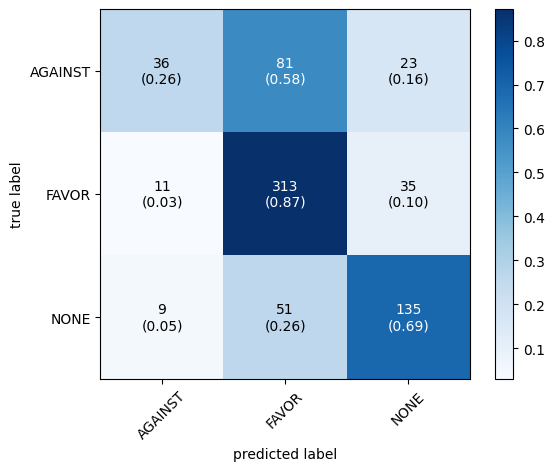

In [ ]:
# With Glove embeddings

# get the predicted labels for the test data
true_labels = [sentence.labels[0].value for sentence in corpus.test]

predicted_labels = []
for sentence in corpus.test:
    classifier_glove.predict(sentence)
    predicted_labels.append(sentence.labels[0].value)

# get the set of unique labels in the predicted and true labels
labels = sorted(set(predicted_labels + true_labels))

# compute the classification report
report = classification_report(true_labels, predicted_labels, labels=labels)
print(report)


# compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

class_names = ['AGAINST', 'FAVOR', 'NONE']

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=class_names)
plt.show()

### Train the Classifier with Flair Embeddings - Dynamic Embeddings

In [ ]:
classifier_flair = TextClassifier(embeddings_flair, label_dictionary= label_dict, label_type=label_type, multi_label=False)

# Define  trainer and start training: Flair embeddings
trainer_flair = ModelTrainer(classifier_flair, corpus)
trainer_flair.train('/content/drive/MyDrive/APP I- FINAL PROJECT/flair_flair', max_epochs=20)

/usr/local/lib/python3.9/dist-packages/flair/trainers/trainer.py:69: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2023-04-17 13:49:00,463 ----------------------------------------------------------------------------------------------------
2023-04-17 13:49:00,468 Model: "TextClassifier(
  (embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.5, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=1024, out_features=1024, bias=True)
    (rnn): GRU(1024, 512, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (weights): None
  (weight_tensor) None
)"
2023-04-17 13:49:00,470 -----------------------------------------------------------------

100%|██████████| 13/13 [00:34<00:00,  2.67s/it]


2023-04-17 13:52:22,253 Evaluating as a multi-label problem: False
2023-04-17 13:52:22,273 DEV : loss 1.0909695625305176 - f1-score (micro avg)  0.419
2023-04-17 13:52:22,444 BAD EPOCHS (no improvement): 0
2023-04-17 13:52:22,451 saving best model
2023-04-17 13:52:22,546 ----------------------------------------------------------------------------------------------------
2023-04-17 13:52:38,482 epoch 2 - iter 5/51 - loss 1.06455280 - time (sec): 15.93 - samples/sec: 10.04 - lr: 0.100000
2023-04-17 13:52:53,670 epoch 2 - iter 10/51 - loss 1.06363987 - time (sec): 31.12 - samples/sec: 10.28 - lr: 0.100000
2023-04-17 13:53:09,852 epoch 2 - iter 15/51 - loss 1.05375352 - time (sec): 47.30 - samples/sec: 10.15 - lr: 0.100000
2023-04-17 13:53:26,156 epoch 2 - iter 20/51 - loss 1.02835559 - time (sec): 63.61 - samples/sec: 10.06 - lr: 0.100000
2023-04-17 13:53:43,341 epoch 2 - iter 25/51 - loss 1.01963482 - time (sec): 80.79 - samples/sec: 9.90 - lr: 0.100000
2023-04-17 13:54:00,057 epoch 2 - 

100%|██████████| 13/13 [00:33<00:00,  2.57s/it]

2023-04-17 13:55:37,789 Evaluating as a multi-label problem: False
2023-04-17 13:55:37,817 DEV : loss 1.282902717590332 - f1-score (micro avg)  0.3666


2023-04-17 13:55:38,109 BAD EPOCHS (no improvement): 1
2023-04-17 13:55:38,117 ----------------------------------------------------------------------------------------------------
2023-04-17 13:55:54,408 epoch 3 - iter 5/51 - loss 1.00967841 - time (sec): 16.29 - samples/sec: 9.82 - lr: 0.100000
2023-04-17 13:56:11,405 epoch 3 - iter 10/51 - loss 0.99549326 - time (sec): 33.29 - samples/sec: 9.61 - lr: 0.100000
2023-04-17 13:56:28,768 epoch 3 - iter 15/51 - loss 0.98067488 - time (sec): 50.65 - samples/sec: 9.48 - lr: 0.100000
2023-04-17 13:56:45,460 epoch 3 - iter 20/51 - loss 0.98879651 - time (sec): 67.34 - samples/sec: 9.50 - lr: 0.100000
2023-04-17 13:57:01,756 epoch 3 - iter 25/51 - loss 0.98702786 - time (sec): 83.64 - samples/sec: 9.57 - lr: 0.100000
2023-04-17 13:57:17,351 epoch 3 - iter 30/51 - loss 0.98112859 - time (sec): 99.23 - samples/sec: 9.67 - lr: 0.100000
2023-04-17 13:57:31,891 epoch 3 - iter 35/51 - loss 0.98488388 - time (sec): 113.77 - samples/sec: 9.84 - lr: 0.1

100%|██████████| 13/13 [00:35<00:00,  2.69s/it]

2023-04-17 13:58:54,512 Evaluating as a multi-label problem: False
2023-04-17 13:58:54,532 DEV : loss 0.9399716258049011 - f1-score (micro avg)  0.581


2023-04-17 13:58:55,470 BAD EPOCHS (no improvement): 0
2023-04-17 13:58:55,483 saving best model
2023-04-17 13:58:55,592 ----------------------------------------------------------------------------------------------------
2023-04-17 13:59:12,057 epoch 4 - iter 5/51 - loss 0.84439387 - time (sec): 16.46 - samples/sec: 9.72 - lr: 0.100000
2023-04-17 13:59:28,475 epoch 4 - iter 10/51 - loss 0.90799155 - time (sec): 32.88 - samples/sec: 9.73 - lr: 0.100000
2023-04-17 13:59:52,028 epoch 4 - iter 15/51 - loss 0.95095652 - time (sec): 56.43 - samples/sec: 8.51 - lr: 0.100000
2023-04-17 14:00:08,293 epoch 4 - iter 20/51 - loss 0.96258421 - time (sec): 72.69 - samples/sec: 8.80 - lr: 0.100000
2023-04-17 14:00:23,001 epoch 4 - iter 25/51 - loss 0.96000425 - time (sec): 87.40 - samples/sec: 9.15 - lr: 0.100000
2023-04-17 14:00:39,027 epoch 4 - iter 30/51 - loss 0.96429036 - time (sec): 103.43 - samples/sec: 9.28 - lr: 0.100000
2023-04-17 14:00:55,625 epoch 4 - iter 35/51 - loss 0.95744462 - time 

100%|██████████| 13/13 [00:35<00:00,  2.75s/it]

2023-04-17 14:02:20,885 Evaluating as a multi-label problem: False
2023-04-17 14:02:20,914 DEV : loss 1.0934422016143799 - f1-score (micro avg)  0.4988


2023-04-17 14:02:21,163 BAD EPOCHS (no improvement): 1
2023-04-17 14:02:21,169 ----------------------------------------------------------------------------------------------------
2023-04-17 14:02:36,504 epoch 5 - iter 5/51 - loss 0.94483931 - time (sec): 15.33 - samples/sec: 10.44 - lr: 0.100000
2023-04-17 14:02:51,802 epoch 5 - iter 10/51 - loss 0.88504648 - time (sec): 30.63 - samples/sec: 10.45 - lr: 0.100000
2023-04-17 14:03:07,551 epoch 5 - iter 15/51 - loss 0.89726468 - time (sec): 46.38 - samples/sec: 10.35 - lr: 0.100000
2023-04-17 14:03:23,809 epoch 5 - iter 20/51 - loss 0.93539796 - time (sec): 62.64 - samples/sec: 10.22 - lr: 0.100000
2023-04-17 14:03:41,908 epoch 5 - iter 25/51 - loss 0.92901160 - time (sec): 80.74 - samples/sec: 9.91 - lr: 0.100000
2023-04-17 14:03:58,563 epoch 5 - iter 30/51 - loss 0.95071121 - time (sec): 97.39 - samples/sec: 9.86 - lr: 0.100000
2023-04-17 14:04:15,011 epoch 5 - iter 35/51 - loss 0.95281924 - time (sec): 113.84 - samples/sec: 9.84 - lr:

100%|██████████| 13/13 [00:33<00:00,  2.62s/it]

2023-04-17 14:05:38,335 Evaluating as a multi-label problem: False
2023-04-17 14:05:38,364 DEV : loss 0.9354330897331238 - f1-score (micro avg)  0.5736


2023-04-17 14:05:38,670 BAD EPOCHS (no improvement): 2
2023-04-17 14:05:38,681 ----------------------------------------------------------------------------------------------------
2023-04-17 14:05:55,060 epoch 6 - iter 5/51 - loss 0.95292704 - time (sec): 16.38 - samples/sec: 9.77 - lr: 0.100000
2023-04-17 14:06:11,071 epoch 6 - iter 10/51 - loss 0.98127621 - time (sec): 32.39 - samples/sec: 9.88 - lr: 0.100000
2023-04-17 14:06:26,817 epoch 6 - iter 15/51 - loss 0.96238096 - time (sec): 48.13 - samples/sec: 9.97 - lr: 0.100000
2023-04-17 14:06:43,125 epoch 6 - iter 20/51 - loss 0.94951814 - time (sec): 64.44 - samples/sec: 9.93 - lr: 0.100000
2023-04-17 14:06:58,904 epoch 6 - iter 25/51 - loss 0.93234835 - time (sec): 80.22 - samples/sec: 9.97 - lr: 0.100000
2023-04-17 14:07:14,722 epoch 6 - iter 30/51 - loss 0.91737417 - time (sec): 96.04 - samples/sec: 10.00 - lr: 0.100000
2023-04-17 14:07:30,017 epoch 6 - iter 35/51 - loss 0.92196768 - time (sec): 111.33 - samples/sec: 10.06 - lr: 0

100%|██████████| 13/13 [00:35<00:00,  2.70s/it]

2023-04-17 14:08:55,664 Evaluating as a multi-label problem: False
2023-04-17 14:08:55,684 DEV : loss 1.0357125997543335 - f1-score (micro avg)  0.5536


2023-04-17 14:08:55,850 BAD EPOCHS (no improvement): 3
2023-04-17 14:08:55,861 ----------------------------------------------------------------------------------------------------
2023-04-17 14:09:11,805 epoch 7 - iter 5/51 - loss 0.91253395 - time (sec): 15.94 - samples/sec: 10.04 - lr: 0.100000
2023-04-17 14:09:27,539 epoch 7 - iter 10/51 - loss 0.90902739 - time (sec): 31.67 - samples/sec: 10.10 - lr: 0.100000
2023-04-17 14:09:47,698 epoch 7 - iter 15/51 - loss 0.90129867 - time (sec): 51.83 - samples/sec: 9.26 - lr: 0.100000
2023-04-17 14:10:03,966 epoch 7 - iter 20/51 - loss 0.91808510 - time (sec): 68.10 - samples/sec: 9.40 - lr: 0.100000
2023-04-17 14:10:20,172 epoch 7 - iter 25/51 - loss 0.90863037 - time (sec): 84.30 - samples/sec: 9.49 - lr: 0.100000
2023-04-17 14:10:36,654 epoch 7 - iter 30/51 - loss 0.91625694 - time (sec): 100.79 - samples/sec: 9.53 - lr: 0.100000
2023-04-17 14:10:52,846 epoch 7 - iter 35/51 - loss 0.92843696 - time (sec): 116.98 - samples/sec: 9.57 - lr: 

100%|██████████| 13/13 [00:33<00:00,  2.57s/it]

2023-04-17 14:12:16,393 Evaluating as a multi-label problem: False
2023-04-17 14:12:16,424 DEV : loss 0.9245901703834534 - f1-score (micro avg)  0.5561


2023-04-17 14:12:16,738 Epoch     7: reducing learning rate of group 0 to 5.0000e-02.
2023-04-17 14:12:16,744 BAD EPOCHS (no improvement): 4
2023-04-17 14:12:16,755 ----------------------------------------------------------------------------------------------------
2023-04-17 14:12:32,729 epoch 8 - iter 5/51 - loss 0.86965672 - time (sec): 15.97 - samples/sec: 10.02 - lr: 0.050000
2023-04-17 14:12:47,999 epoch 8 - iter 10/51 - loss 0.87861537 - time (sec): 31.24 - samples/sec: 10.24 - lr: 0.050000
2023-04-17 14:13:05,300 epoch 8 - iter 15/51 - loss 0.86823130 - time (sec): 48.54 - samples/sec: 9.89 - lr: 0.050000
2023-04-17 14:13:22,292 epoch 8 - iter 20/51 - loss 0.84465336 - time (sec): 65.53 - samples/sec: 9.77 - lr: 0.050000
2023-04-17 14:13:38,814 epoch 8 - iter 25/51 - loss 0.84362648 - time (sec): 82.06 - samples/sec: 9.75 - lr: 0.050000
2023-04-17 14:13:54,318 epoch 8 - iter 30/51 - loss 0.84181178 - time (sec): 97.56 - samples/sec: 9.84 - lr: 0.050000
2023-04-17 14:14:09,536 e

100%|██████████| 13/13 [00:35<00:00,  2.73s/it]

2023-04-17 14:15:31,404 Evaluating as a multi-label problem: False
2023-04-17 14:15:31,423 DEV : loss 0.8928911685943604 - f1-score (micro avg)  0.5885


2023-04-17 14:15:32,358 BAD EPOCHS (no improvement): 0
2023-04-17 14:15:32,367 saving best model
2023-04-17 14:15:32,505 ----------------------------------------------------------------------------------------------------
2023-04-17 14:15:48,748 epoch 9 - iter 5/51 - loss 0.79251163 - time (sec): 16.23 - samples/sec: 9.86 - lr: 0.050000
2023-04-17 14:16:05,119 epoch 9 - iter 10/51 - loss 0.81468739 - time (sec): 32.60 - samples/sec: 9.82 - lr: 0.050000
2023-04-17 14:16:19,957 epoch 9 - iter 15/51 - loss 0.83386197 - time (sec): 47.44 - samples/sec: 10.12 - lr: 0.050000
2023-04-17 14:16:35,213 epoch 9 - iter 20/51 - loss 0.82487486 - time (sec): 62.69 - samples/sec: 10.21 - lr: 0.050000
2023-04-17 14:16:51,164 epoch 9 - iter 25/51 - loss 0.81226056 - time (sec): 78.64 - samples/sec: 10.17 - lr: 0.050000
2023-04-17 14:17:07,542 epoch 9 - iter 30/51 - loss 0.82071067 - time (sec): 95.02 - samples/sec: 10.10 - lr: 0.050000
2023-04-17 14:17:23,802 epoch 9 - iter 35/51 - loss 0.81729338 - ti

100%|██████████| 13/13 [00:34<00:00,  2.62s/it]

2023-04-17 14:18:45,539 Evaluating as a multi-label problem: False
2023-04-17 14:18:45,570 DEV : loss 0.8748942017555237 - f1-score (micro avg)  0.601


2023-04-17 14:18:45,880 BAD EPOCHS (no improvement): 0
2023-04-17 14:18:45,891 saving best model
2023-04-17 14:18:46,034 ----------------------------------------------------------------------------------------------------
2023-04-17 14:19:02,465 epoch 10 - iter 5/51 - loss 0.83771685 - time (sec): 16.43 - samples/sec: 9.74 - lr: 0.050000
2023-04-17 14:19:19,505 epoch 10 - iter 10/51 - loss 0.85777424 - time (sec): 33.47 - samples/sec: 9.56 - lr: 0.050000
2023-04-17 14:19:35,305 epoch 10 - iter 15/51 - loss 0.82867293 - time (sec): 49.27 - samples/sec: 9.74 - lr: 0.050000
2023-04-17 14:19:57,561 epoch 10 - iter 20/51 - loss 0.80988640 - time (sec): 71.52 - samples/sec: 8.95 - lr: 0.050000
2023-04-17 14:20:14,357 epoch 10 - iter 25/51 - loss 0.79746108 - time (sec): 88.32 - samples/sec: 9.06 - lr: 0.050000
2023-04-17 14:20:31,010 epoch 10 - iter 30/51 - loss 0.81350088 - time (sec): 104.97 - samples/sec: 9.15 - lr: 0.050000
2023-04-17 14:20:47,844 epoch 10 - iter 35/51 - loss 0.81329681 

100%|██████████| 13/13 [00:33<00:00,  2.56s/it]

2023-04-17 14:22:10,634 Evaluating as a multi-label problem: False
2023-04-17 14:22:10,659 DEV : loss 0.8976933360099792 - f1-score (micro avg)  0.6209


2023-04-17 14:22:10,962 BAD EPOCHS (no improvement): 0
2023-04-17 14:22:10,972 saving best model
2023-04-17 14:22:11,098 ----------------------------------------------------------------------------------------------------
2023-04-17 14:22:27,447 epoch 11 - iter 5/51 - loss 0.80799520 - time (sec): 16.34 - samples/sec: 9.79 - lr: 0.050000
2023-04-17 14:22:43,773 epoch 11 - iter 10/51 - loss 0.79609947 - time (sec): 32.67 - samples/sec: 9.80 - lr: 0.050000
2023-04-17 14:22:59,318 epoch 11 - iter 15/51 - loss 0.83320835 - time (sec): 48.21 - samples/sec: 9.96 - lr: 0.050000
2023-04-17 14:23:15,800 epoch 11 - iter 20/51 - loss 0.82537383 - time (sec): 64.69 - samples/sec: 9.89 - lr: 0.050000
2023-04-17 14:23:31,387 epoch 11 - iter 25/51 - loss 0.83267322 - time (sec): 80.28 - samples/sec: 9.97 - lr: 0.050000
2023-04-17 14:23:46,723 epoch 11 - iter 30/51 - loss 0.83917236 - time (sec): 95.62 - samples/sec: 10.04 - lr: 0.050000
2023-04-17 14:24:04,031 epoch 11 - iter 35/51 - loss 0.83976020 

100%|██████████| 13/13 [00:35<00:00,  2.70s/it]

2023-04-17 14:25:29,944 Evaluating as a multi-label problem: False
2023-04-17 14:25:29,964 DEV : loss 0.9774742722511292 - f1-score (micro avg)  0.5611


2023-04-17 14:25:30,145 BAD EPOCHS (no improvement): 1
2023-04-17 14:25:30,153 ----------------------------------------------------------------------------------------------------
2023-04-17 14:25:45,923 epoch 12 - iter 5/51 - loss 0.79952484 - time (sec): 15.77 - samples/sec: 10.15 - lr: 0.050000
2023-04-17 14:26:02,712 epoch 12 - iter 10/51 - loss 0.75661169 - time (sec): 32.56 - samples/sec: 9.83 - lr: 0.050000
2023-04-17 14:26:18,310 epoch 12 - iter 15/51 - loss 0.81076745 - time (sec): 48.15 - samples/sec: 9.97 - lr: 0.050000
2023-04-17 14:26:33,288 epoch 12 - iter 20/51 - loss 0.79913455 - time (sec): 63.13 - samples/sec: 10.14 - lr: 0.050000
2023-04-17 14:26:49,472 epoch 12 - iter 25/51 - loss 0.79514517 - time (sec): 79.32 - samples/sec: 10.09 - lr: 0.050000
2023-04-17 14:27:05,822 epoch 12 - iter 30/51 - loss 0.80016902 - time (sec): 95.67 - samples/sec: 10.03 - lr: 0.050000
2023-04-17 14:27:22,319 epoch 12 - iter 35/51 - loss 0.78477504 - time (sec): 112.16 - samples/sec: 9.9

100%|██████████| 13/13 [00:33<00:00,  2.58s/it]

2023-04-17 14:28:46,502 Evaluating as a multi-label problem: False
2023-04-17 14:28:46,528 DEV : loss 0.8354817628860474 - f1-score (micro avg)  0.6085


2023-04-17 14:28:46,840 BAD EPOCHS (no improvement): 2
2023-04-17 14:28:46,848 ----------------------------------------------------------------------------------------------------
2023-04-17 14:29:02,307 epoch 13 - iter 5/51 - loss 0.63858609 - time (sec): 15.46 - samples/sec: 10.35 - lr: 0.050000
2023-04-17 14:29:18,130 epoch 13 - iter 10/51 - loss 0.70562196 - time (sec): 31.28 - samples/sec: 10.23 - lr: 0.050000
2023-04-17 14:29:34,891 epoch 13 - iter 15/51 - loss 0.74976528 - time (sec): 48.04 - samples/sec: 9.99 - lr: 0.050000
2023-04-17 14:29:51,388 epoch 13 - iter 20/51 - loss 0.75065183 - time (sec): 64.54 - samples/sec: 9.92 - lr: 0.050000
2023-04-17 14:30:14,099 epoch 13 - iter 25/51 - loss 0.76522121 - time (sec): 87.25 - samples/sec: 9.17 - lr: 0.050000
2023-04-17 14:30:30,512 epoch 13 - iter 30/51 - loss 0.77671898 - time (sec): 103.66 - samples/sec: 9.26 - lr: 0.050000
2023-04-17 14:30:46,113 epoch 13 - iter 35/51 - loss 0.77415115 - time (sec): 119.26 - samples/sec: 9.39

100%|██████████| 13/13 [00:35<00:00,  2.75s/it]

2023-04-17 14:32:09,568 Evaluating as a multi-label problem: False
2023-04-17 14:32:09,588 DEV : loss 0.8391220569610596 - f1-score (micro avg)  0.6384


2023-04-17 14:32:10,562 BAD EPOCHS (no improvement): 0
2023-04-17 14:32:10,570 saving best model
2023-04-17 14:32:10,665 ----------------------------------------------------------------------------------------------------
2023-04-17 14:32:26,996 epoch 14 - iter 5/51 - loss 0.73492343 - time (sec): 16.32 - samples/sec: 9.80 - lr: 0.050000
2023-04-17 14:32:43,359 epoch 14 - iter 10/51 - loss 0.76968110 - time (sec): 32.69 - samples/sec: 9.79 - lr: 0.050000
2023-04-17 14:33:00,041 epoch 14 - iter 15/51 - loss 0.80787081 - time (sec): 49.37 - samples/sec: 9.72 - lr: 0.050000
2023-04-17 14:33:15,633 epoch 14 - iter 20/51 - loss 0.79417524 - time (sec): 64.96 - samples/sec: 9.85 - lr: 0.050000
2023-04-17 14:33:31,281 epoch 14 - iter 25/51 - loss 0.80872095 - time (sec): 80.61 - samples/sec: 9.92 - lr: 0.050000
2023-04-17 14:33:46,556 epoch 14 - iter 30/51 - loss 0.81534008 - time (sec): 95.88 - samples/sec: 10.01 - lr: 0.050000
2023-04-17 14:34:02,741 epoch 14 - iter 35/51 - loss 0.81278219 

100%|██████████| 13/13 [00:37<00:00,  2.85s/it]

2023-04-17 14:35:29,098 Evaluating as a multi-label problem: False
2023-04-17 14:35:29,119 DEV : loss 0.8199353218078613 - f1-score (micro avg)  0.6309


2023-04-17 14:35:29,287 BAD EPOCHS (no improvement): 1
2023-04-17 14:35:29,299 ----------------------------------------------------------------------------------------------------
2023-04-17 14:35:45,471 epoch 15 - iter 5/51 - loss 0.79840593 - time (sec): 16.17 - samples/sec: 9.89 - lr: 0.050000
2023-04-17 14:36:00,545 epoch 15 - iter 10/51 - loss 0.89343709 - time (sec): 31.24 - samples/sec: 10.24 - lr: 0.050000
2023-04-17 14:36:16,186 epoch 15 - iter 15/51 - loss 0.82909272 - time (sec): 46.89 - samples/sec: 10.24 - lr: 0.050000
2023-04-17 14:36:32,384 epoch 15 - iter 20/51 - loss 0.77765652 - time (sec): 63.08 - samples/sec: 10.15 - lr: 0.050000
2023-04-17 14:36:48,909 epoch 15 - iter 25/51 - loss 0.77707741 - time (sec): 79.61 - samples/sec: 10.05 - lr: 0.050000
2023-04-17 14:37:05,313 epoch 15 - iter 30/51 - loss 0.76642119 - time (sec): 96.01 - samples/sec: 10.00 - lr: 0.050000
2023-04-17 14:37:21,424 epoch 15 - iter 35/51 - loss 0.76161175 - time (sec): 112.12 - samples/sec: 9.

100%|██████████| 13/13 [00:33<00:00,  2.56s/it]

2023-04-17 14:38:43,324 Evaluating as a multi-label problem: False
2023-04-17 14:38:43,343 DEV : loss 0.8667097091674805 - f1-score (micro avg)  0.5885


2023-04-17 14:38:43,634 BAD EPOCHS (no improvement): 2
2023-04-17 14:38:43,646 ----------------------------------------------------------------------------------------------------
2023-04-17 14:38:59,682 epoch 16 - iter 5/51 - loss 0.68508823 - time (sec): 16.03 - samples/sec: 9.98 - lr: 0.050000
2023-04-17 14:39:15,801 epoch 16 - iter 10/51 - loss 0.77043414 - time (sec): 32.15 - samples/sec: 9.95 - lr: 0.050000
2023-04-17 14:39:32,020 epoch 16 - iter 15/51 - loss 0.77322162 - time (sec): 48.37 - samples/sec: 9.92 - lr: 0.050000
2023-04-17 14:39:48,502 epoch 16 - iter 20/51 - loss 0.77367795 - time (sec): 64.85 - samples/sec: 9.87 - lr: 0.050000
2023-04-17 14:40:03,704 epoch 16 - iter 25/51 - loss 0.77998158 - time (sec): 80.06 - samples/sec: 9.99 - lr: 0.050000
2023-04-17 14:40:19,131 epoch 16 - iter 30/51 - loss 0.78185402 - time (sec): 95.48 - samples/sec: 10.05 - lr: 0.050000
2023-04-17 14:40:34,525 epoch 16 - iter 35/51 - loss 0.78021707 - time (sec): 110.88 - samples/sec: 10.10 

100%|██████████| 13/13 [00:34<00:00,  2.68s/it]

2023-04-17 14:42:00,165 Evaluating as a multi-label problem: False
2023-04-17 14:42:00,185 DEV : loss 0.9375843405723572 - f1-score (micro avg)  0.6035


2023-04-17 14:42:00,350 BAD EPOCHS (no improvement): 3
2023-04-17 14:42:00,360 ----------------------------------------------------------------------------------------------------
2023-04-17 14:42:16,349 epoch 17 - iter 5/51 - loss 0.79808083 - time (sec): 15.99 - samples/sec: 10.01 - lr: 0.050000
2023-04-17 14:42:32,382 epoch 17 - iter 10/51 - loss 0.81763687 - time (sec): 32.02 - samples/sec: 9.99 - lr: 0.050000
2023-04-17 14:42:46,377 epoch 17 - iter 15/51 - loss 0.81490749 - time (sec): 46.01 - samples/sec: 10.43 - lr: 0.050000
2023-04-17 14:43:02,078 epoch 17 - iter 20/51 - loss 0.80234442 - time (sec): 61.72 - samples/sec: 10.37 - lr: 0.050000
2023-04-17 14:43:19,295 epoch 17 - iter 25/51 - loss 0.78436703 - time (sec): 78.93 - samples/sec: 10.14 - lr: 0.050000
2023-04-17 14:43:35,151 epoch 17 - iter 30/51 - loss 0.79446078 - time (sec): 94.79 - samples/sec: 10.13 - lr: 0.050000
2023-04-17 14:43:51,354 epoch 17 - iter 35/51 - loss 0.78406251 - time (sec): 110.99 - samples/sec: 10

100%|██████████| 13/13 [00:33<00:00,  2.58s/it]

2023-04-17 14:45:13,251 Evaluating as a multi-label problem: False
2023-04-17 14:45:13,269 DEV : loss 0.8988823294639587 - f1-score (micro avg)  0.5885


2023-04-17 14:45:13,481 Epoch    17: reducing learning rate of group 0 to 2.5000e-02.
2023-04-17 14:45:13,486 BAD EPOCHS (no improvement): 4
2023-04-17 14:45:13,505 ----------------------------------------------------------------------------------------------------
2023-04-17 14:45:29,559 epoch 18 - iter 5/51 - loss 0.80373957 - time (sec): 16.05 - samples/sec: 9.97 - lr: 0.025000
2023-04-17 14:45:46,139 epoch 18 - iter 10/51 - loss 0.74632616 - time (sec): 32.63 - samples/sec: 9.81 - lr: 0.025000
2023-04-17 14:46:03,169 epoch 18 - iter 15/51 - loss 0.71274770 - time (sec): 49.66 - samples/sec: 9.67 - lr: 0.025000
2023-04-17 14:46:19,928 epoch 18 - iter 20/51 - loss 0.73309090 - time (sec): 66.42 - samples/sec: 9.64 - lr: 0.025000
2023-04-17 14:46:36,451 epoch 18 - iter 25/51 - loss 0.73736778 - time (sec): 82.94 - samples/sec: 9.65 - lr: 0.025000
2023-04-17 14:46:51,185 epoch 18 - iter 30/51 - loss 0.72695464 - time (sec): 97.68 - samples/sec: 9.83 - lr: 0.025000
2023-04-17 14:47:05,6

100%|██████████| 13/13 [00:40<00:00,  3.15s/it]

2023-04-17 14:48:35,725 Evaluating as a multi-label problem: False
2023-04-17 14:48:35,763 DEV : loss 0.8733363151550293 - f1-score (micro avg)  0.6209


2023-04-17 14:48:36,743 BAD EPOCHS (no improvement): 1
2023-04-17 14:48:36,752 ----------------------------------------------------------------------------------------------------
2023-04-17 14:48:53,800 epoch 19 - iter 5/51 - loss 0.70439796 - time (sec): 17.04 - samples/sec: 9.39 - lr: 0.025000
2023-04-17 14:49:10,937 epoch 19 - iter 10/51 - loss 0.70309998 - time (sec): 34.18 - samples/sec: 9.36 - lr: 0.025000
2023-04-17 14:49:27,528 epoch 19 - iter 15/51 - loss 0.72027628 - time (sec): 50.77 - samples/sec: 9.45 - lr: 0.025000
2023-04-17 14:49:43,191 epoch 19 - iter 20/51 - loss 0.71170923 - time (sec): 66.43 - samples/sec: 9.63 - lr: 0.025000
2023-04-17 14:49:58,375 epoch 19 - iter 25/51 - loss 0.71506695 - time (sec): 81.62 - samples/sec: 9.80 - lr: 0.025000
2023-04-17 14:50:13,828 epoch 19 - iter 30/51 - loss 0.70749320 - time (sec): 97.07 - samples/sec: 9.89 - lr: 0.025000
2023-04-17 14:50:30,527 epoch 19 - iter 35/51 - loss 0.69904932 - time (sec): 113.77 - samples/sec: 9.84 - 

100%|██████████| 13/13 [00:35<00:00,  2.77s/it]

2023-04-17 14:51:56,721 Evaluating as a multi-label problem: False
2023-04-17 14:51:56,742 DEV : loss 0.8764120936393738 - f1-score (micro avg)  0.6209


2023-04-17 14:51:56,934 BAD EPOCHS (no improvement): 2
2023-04-17 14:51:56,943 ----------------------------------------------------------------------------------------------------
2023-04-17 14:52:13,786 epoch 20 - iter 5/51 - loss 0.83903114 - time (sec): 16.84 - samples/sec: 9.50 - lr: 0.025000
2023-04-17 14:52:29,515 epoch 20 - iter 10/51 - loss 0.78423204 - time (sec): 32.57 - samples/sec: 9.83 - lr: 0.025000
2023-04-17 14:52:44,898 epoch 20 - iter 15/51 - loss 0.75255797 - time (sec): 47.95 - samples/sec: 10.01 - lr: 0.025000
2023-04-17 14:53:00,926 epoch 20 - iter 20/51 - loss 0.75098912 - time (sec): 63.98 - samples/sec: 10.00 - lr: 0.025000
2023-04-17 14:53:17,304 epoch 20 - iter 25/51 - loss 0.76056244 - time (sec): 80.36 - samples/sec: 9.96 - lr: 0.025000
2023-04-17 14:53:33,343 epoch 20 - iter 30/51 - loss 0.75328226 - time (sec): 96.40 - samples/sec: 9.96 - lr: 0.025000
2023-04-17 14:53:49,738 epoch 20 - iter 35/51 - loss 0.74730343 - time (sec): 112.79 - samples/sec: 9.93 

100%|██████████| 13/13 [00:34<00:00,  2.63s/it]

2023-04-17 14:55:13,290 Evaluating as a multi-label problem: False
2023-04-17 14:55:13,315 DEV : loss 0.8062639236450195 - f1-score (micro avg)  0.6534


2023-04-17 14:55:13,622 BAD EPOCHS (no improvement): 0
2023-04-17 14:55:13,633 saving best model
2023-04-17 14:55:14,378 ----------------------------------------------------------------------------------------------------


100%|██████████| 22/22 [00:52<00:00,  2.40s/it]

2023-04-17 14:56:07,736 Evaluating as a multi-label problem: False


2023-04-17 14:56:07,764 0.7147	0.7147	0.7147	0.7147
2023-04-17 14:56:07,769 
Results:
- F-score (micro) 0.7147
- F-score (macro) 0.6796
- Accuracy 0.7147

By class:
              precision    recall  f1-score   support

       FAVOR     0.7668    0.7967    0.7814       359
        NONE     0.7430    0.6821    0.7112       195
     AGAINST     0.5423    0.5500    0.5461       140

    accuracy                         0.7147       694
   macro avg     0.6840    0.6762    0.6796       694
weighted avg     0.7148    0.7147    0.7142       694

2023-04-17 14:56:07,775 ----------------------------------------------------------------------------------------------------


{'test_score': 0.7146974063400576,
 'dev_score_history': [0.41895261845386533,
  0.36658354114713215,
  0.5810473815461347,
  0.49875311720698257,
  0.57356608478803,
  0.5536159600997507,
  0.5561097256857855,
  0.5885286783042394,
  0.600997506234414,
  0.6209476309226932,
  0.5610972568578554,
  0.6084788029925187,
  0.6384039900249376,
  0.6309226932668329,
  0.5885286783042394,
  0.6034912718204489,
  0.5885286783042394,
  0.6209476309226932,
  0.6209476309226932,
  0.6533665835411472],
 'train_loss_history': [1.0914924913428994,
  1.0054335583759455,
  0.9844960830036025,
  0.9517225354500627,
  0.9583515530073092,
  0.9230814611867126,
  0.9218371750858988,
  0.8415401405311851,
  0.8228825939430875,
  0.8070520534646347,
  0.8113930865322309,
  0.805446609277999,
  0.7805938686473242,
  0.7769804605086347,
  0.7656390705656321,
  0.7749583204736126,
  0.7810372069533844,
  0.7211572483981891,
  0.7131465828225259,
  0.7331194794282186],
 'dev_loss_history': [1.0909695625305176,

### Evaluating the Classifier with Flair Embeddings

              precision    recall  f1-score   support

     AGAINST       0.54      0.55      0.55       140
       FAVOR       0.77      0.80      0.78       359
        NONE       0.74      0.68      0.71       195

    accuracy                           0.71       694
   macro avg       0.68      0.68      0.68       694
weighted avg       0.71      0.71      0.71       694



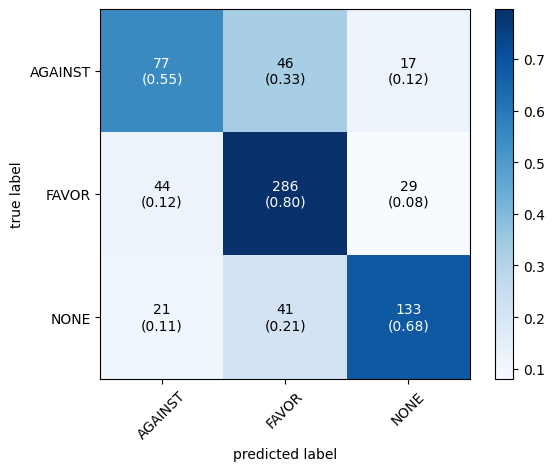

In [ ]:
# With Flair embeddings

# get the predicted labels for the test data
true_labels = [sentence.labels[0].value for sentence in corpus.test]

predicted_labels = []
for sentence in corpus.test:
    classifier_flair.predict(sentence)
    predicted_labels.append(sentence.labels[0].value)

# get the set of unique labels in the predicted and true labels
labels = sorted(set(predicted_labels + true_labels))

# compute the classification report
report = classification_report(true_labels, predicted_labels, labels=labels)
print(report)


# compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=labels)

class_names = ['AGAINST', 'FAVOR', 'NONE']

fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=class_names)
plt.show()

# HuggingFace Models

### Logging into Huggingface to push the models

In [ ]:
# login to huggingface
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### Helper functions to train the huggingface model

In [ ]:
accuracy = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def load_data_into_hf(train_fname, test_fname):
  train_dataset = load_dataset("csv", data_files=train_fname)["train"]
  test_dataset = load_dataset("csv", data_files=test_fname)["train"]

  train_dataset = train_dataset.remove_columns(["Unnamed: 0", "tweet_id", "user_id", "text"])
  test_dataset = test_dataset.remove_columns(["Unnamed: 0", "tweet_id", "user_id", "text"])

  dataset = DatasetDict({
      "train": train_dataset,
      "test": test_dataset
  })

  return dataset.class_encode_column("label")


def load_tokenizer(tokenizer_name):
  return AutoTokenizer.from_pretrained(tokenizer_name)

def load_model(model_name, num_labels, id2label, label2id):
  return AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels, id2label=id2label, label2id=label2id
  )
f1_metric = evaluate.load("f1")
def get_training_args(output_model_name):
  return TrainingArguments(
    output_dir=output_model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    metric_for_best_model="f1",
  )

def get_data_collator(tokenizer):
  return DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

def compute_metrics(eval_pred):

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1_metric.compute(predictions=predictions, references=labels, average="micro")


def tokenize(examples):
    return tokenizer(examples["preprocessed_text"], truncation=True, padding=True)



def define_trainer(model, training_args, dataset, tokenizer, data_collator, compute_metrics):
  return Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
  )



### Training different huggingface models

In [ ]:
id2label = {0: "AGAINST", 1: "FAVOR", 2: "NONE"}
label2id = {"AGAINST": 0, "FAVOR": 1, "NONE": 2}
num_labels = 3

dataset = load_data_into_hf(preprocessed_train_csv_file, preprocessed_test_csv_file)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-0be0231f6b5bfcfb/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-c616dccd6c384932/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Casting to class labels:   0%|          | 0/2003 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/694 [00:00<?, ? examples/s]

### Multi-lingual BERT Based Models

In [ ]:
model_ckpts = [
    "bert-base-multilingual-uncased",
    "bert-base-multilingual-cased",
]

for model_ckpt in model_ckpts:
  print(model_ckpt)
  tokenizer = load_tokenizer(model_ckpt)
  model = load_model(model_ckpt, num_labels, id2label, label2id)

  tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=["preprocessed_text"])

  data_collator = get_data_collator(tokenizer)
  training_args = get_training_args(f"{model_ckpt}_vaxxstance_spanish")
  trainer = define_trainer(model, training_args, tokenized_dataset, tokenizer, data_collator, compute_metrics)

  trainer.train()
  trainer.push_to_hub()

bert-base-multilingual-uncased


Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

Map:   0%|          | 0/2003 [00:00<?, ? examples/s]

Map:   0%|          | 0/694 [00:00<?, ? examples/s]

Cloning https://huggingface.co/nouman-10/bert-base-multilingual-uncased_vaxxstance_spanish into local empty directory.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.601845,0.762248
2,No log,0.544256,0.783862
3,No log,0.567366,0.805476
4,0.513700,0.584130,0.795389
5,0.513700,0.646608,0.802594


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/638M [00:00<?, ?B/s]

Upload file runs/Apr17_15-33-49_f89fff326edd/events.out.tfevents.1681745639.f89fff326edd.290.0:   0%|         …

To https://huggingface.co/nouman-10/bert-base-multilingual-uncased_vaxxstance_spanish
   a05b40a..14d9de1  main -> main

   a05b40a..14d9de1  main -> main

To https://huggingface.co/nouman-10/bert-base-multilingual-uncased_vaxxstance_spanish
   14d9de1..b751496  main -> main

   14d9de1..b751496  main -> main



bert-base-multilingual-cased


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Map:   0%|          | 0/2003 [00:00<?, ? examples/s]

Map:   0%|          | 0/694 [00:00<?, ? examples/s]

Cloning https://huggingface.co/nouman-10/bert-base-multilingual-cased_vaxxstance_spanish into local empty directory.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.630468,0.772334
2,No log,0.544083,0.780980
3,No log,0.590899,0.795389
4,0.516100,0.633945,0.785303
5,0.516100,0.708455,0.785303


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/679M [00:00<?, ?B/s]

Upload file runs/Apr17_15-43-15_f89fff326edd/events.out.tfevents.1681746201.f89fff326edd.290.2:   0%|         …

To https://huggingface.co/nouman-10/bert-base-multilingual-cased_vaxxstance_spanish
   95bd5d7..9a948f7  main -> main

   95bd5d7..9a948f7  main -> main

To https://huggingface.co/nouman-10/bert-base-multilingual-cased_vaxxstance_spanish
   9a948f7..5146d13  main -> main

   9a948f7..5146d13  main -> main



### BERT models pre-trained on Spanish Corpora

In [ ]:
model_ckpts = [
    "dccuchile/bert-base-spanish-wwm-cased",
    "dccuchile/bert-base-spanish-wwm-uncased",
]

for model_ckpt in model_ckpts:
  print(model_ckpt)
  tokenizer = load_tokenizer(model_ckpt)
  model = load_model(model_ckpt, num_labels, id2label, label2id)

  tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=["preprocessed_text"])

  data_collator = get_data_collator(tokenizer)
  training_args = get_training_args(f"{model_ckpt}_vaxxstance_spanish")
  trainer = define_trainer(model, training_args, tokenized_dataset, tokenizer, data_collator, compute_metrics)

  trainer.train()
  trainer.push_to_hub()

dccuchile/bert-base-spanish-wwm-cased


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

Map:   0%|          | 0/2003 [00:00<?, ? examples/s]

Map:   0%|          | 0/694 [00:00<?, ? examples/s]

Cloning https://huggingface.co/nouman-10/bert-base-spanish-wwm-cased_vaxxstance_spanish into local empty directory.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.508111,0.801153
2,No log,0.490867,0.802594
3,No log,0.536550,0.808357
4,0.407500,0.633636,0.814121
5,0.407500,0.696974,0.815562


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/419M [00:00<?, ?B/s]

Upload file runs/Apr17_17-04-44_5038b1f03a26/events.out.tfevents.1681751096.5038b1f03a26.336.0:   0%|         …

To https://huggingface.co/nouman-10/bert-base-spanish-wwm-cased_vaxxstance_spanish
   4c52dc8..5d24e85  main -> main

   4c52dc8..5d24e85  main -> main

To https://huggingface.co/nouman-10/bert-base-spanish-wwm-cased_vaxxstance_spanish
   5d24e85..e0d03e7  main -> main

   5d24e85..e0d03e7  main -> main



dccuchile/bert-base-spanish-wwm-uncased


Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuc

Map:   0%|          | 0/2003 [00:00<?, ? examples/s]

Map:   0%|          | 0/694 [00:00<?, ? examples/s]

Cloning https://huggingface.co/nouman-10/bert-base-spanish-wwm-uncased_vaxxstance_spanish into local empty directory.


Download file pytorch_model.bin:   0%|          | 7.40k/419M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.62k/3.62k [00:00<?, ?B/s]

Download file runs/Apr17_16-15-29_f89fff326edd/1681748136.0661244/events.out.tfevents.1681748136.f89fff326edd.…

Clean file training_args.bin:  28%|##7       | 1.00k/3.62k [00:00<?, ?B/s]

Clean file runs/Apr17_16-15-29_f89fff326edd/1681748136.0661244/events.out.tfevents.1681748136.f89fff326edd.290…

Download file runs/Apr17_16-15-29_f89fff326edd/events.out.tfevents.1681748136.f89fff326edd.290.10: 100%|######…

Clean file runs/Apr17_16-15-29_f89fff326edd/events.out.tfevents.1681748136.f89fff326edd.290.10:  16%|#6       …

Clean file pytorch_model.bin:   0%|          | 1.00k/419M [00:00<?, ?B/s]

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.546843,0.779539
2,No log,0.509674,0.792507
3,No log,0.651525,0.789625
4,0.407800,0.701050,0.801153
5,0.407800,0.770003,0.804035


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Apr17_17-12-47_5038b1f03a26/events.out.tfevents.1681751687.5038b1f03a26.336.2:   0%|         …

To https://huggingface.co/nouman-10/bert-base-spanish-wwm-uncased_vaxxstance_spanish
   625d9e6..e6a8a18  main -> main

   625d9e6..e6a8a18  main -> main



### RoBERTa pre-trained on Spanish

In [ ]:
model_ckpt = "bertin-project/bertin-roberta-base-spanish"

tokenizer = load_tokenizer(model_ckpt)
model = load_model(model_ckpt, num_labels, id2label, label2id)

tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=["preprocessed_text"])

data_collator = get_data_collator(tokenizer)
training_args = get_training_args(f"{model_ckpt}_vaxxstance_spanish")
trainer = define_trainer(model, training_args, tokenized_dataset, tokenizer, data_collator, compute_metrics)

trainer.train()
trainer.push_to_hub()

Some weights of the model checkpoint at bertin-project/bertin-roberta-base-spanish were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at bertin-project/bertin-roberta-base-spanish and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'class

Map:   0%|          | 0/2003 [00:00<?, ? examples/s]

Map:   0%|          | 0/694 [00:00<?, ? examples/s]

Cloning https://huggingface.co/nouman-10/bertin-roberta-base-spanish_vaxxstance_spanish into local empty directory.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.830209,0.678674
2,No log,0.624842,0.769452
3,No log,0.522261,0.799712
4,0.579900,0.606825,0.808357
5,0.579900,0.667813,0.814121


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/476M [00:00<?, ?B/s]

Upload file runs/Apr18_10-35-23_34dd15bc4565/events.out.tfevents.1681814133.34dd15bc4565.301.0:   0%|         …

To https://huggingface.co/nouman-10/bertin-roberta-base-spanish_vaxxstance_spanish
   fb5d461..034c50e  main -> main

   fb5d461..034c50e  main -> main

To https://huggingface.co/nouman-10/bertin-roberta-base-spanish_vaxxstance_spanish
   034c50e..a11dc87  main -> main

   034c50e..a11dc87  main -> main



'https://huggingface.co/nouman-10/bertin-roberta-base-spanish_vaxxstance_spanish/commit/034c50ec32644b80bfbc81be66971be40919bfe0'

### XLM-RoBERTa based models (Multi-lingual)

XLM-Roberta-base

In [ ]:
model_ckpt = "xlm-roberta-base"

tokenizer = load_tokenizer(model_ckpt)
model = load_model(model_ckpt, num_labels, id2label, label2id)

tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=["preprocessed_text"])

data_collator = get_data_collator(tokenizer)
training_args = get_training_args(f"{model_ckpt}_vaxxstance_spanish")
trainer = define_trainer(model, training_args, tokenized_dataset, tokenizer, data_collator, compute_metrics)

trainer.train()
trainer.push_to_hub()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Map:   0%|          | 0/2003 [00:00<?, ? examples/s]

Map:   0%|          | 0/694 [00:00<?, ? examples/s]

Cloning https://huggingface.co/nouman-10/xlm-roberta-base_vaxxstance_spanish into local empty directory.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.715222,0.726225
2,No log,0.561577,0.783862
3,No log,0.601131,0.780980
4,0.676600,0.529540,0.819885
5,0.676600,0.557360,0.814121


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Apr18_13-23-53_a59b33d71a0c/events.out.tfevents.1681824244.a59b33d71a0c.542.0:   0%|         …

To https://huggingface.co/nouman-10/xlm-roberta-base_vaxxstance_spanish
   51ae242..cea85cd  main -> main

   51ae242..cea85cd  main -> main

To https://huggingface.co/nouman-10/xlm-roberta-base_vaxxstance_spanish
   cea85cd..c944864  main -> main

   cea85cd..c944864  main -> main



'https://huggingface.co/nouman-10/xlm-roberta-base_vaxxstance_spanish/commit/cea85cd10fd4e0ff242f8a2148ddc6266698e047'

XLM-Roberta-large

In [ ]:
model_ckpt = "xlm-roberta-large"

tokenizer = load_tokenizer(model_ckpt)
model = load_model(model_ckpt, num_labels, id2label, label2id)

tokenized_dataset = dataset.map(tokenize, batched=True, remove_columns=["preprocessed_text"])

data_collator = get_data_collator(tokenizer)
training_args = get_training_args(f"{model_ckpt}_vaxxstance_spanish")
trainer = define_trainer(model, training_args, tokenized_dataset, tokenizer, data_collator, compute_metrics)

trainer.train()
trainer.push_to_hub()

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.out

Map:   0%|          | 0/2003 [00:00<?, ? examples/s]

Map:   0%|          | 0/694 [00:00<?, ? examples/s]

Cloning https://huggingface.co/nouman-10/xlm-roberta-large_vaxxstance_spanish into local empty directory.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.764813,0.668588
2,No log,0.518839,0.812680
3,No log,0.541666,0.788184
4,0.676200,0.482855,0.828530
5,0.676200,0.518640,0.828530


Adding files tracked by Git LFS: ['tokenizer.json']. This may take a bit of time if the files are large.
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Apr18_15-26-32_640ca81a79e1/events.out.tfevents.1681831606.640ca81a79e1.166.0:   0%|         …

To https://huggingface.co/nouman-10/xlm-roberta-large_vaxxstance_spanish
   52d4983..53f80a7  main -> main

   52d4983..53f80a7  main -> main

To https://huggingface.co/nouman-10/xlm-roberta-large_vaxxstance_spanish
   53f80a7..f350184  main -> main

   53f80a7..f350184  main -> main



'https://huggingface.co/nouman-10/xlm-roberta-large_vaxxstance_spanish/commit/53f80a77a37712029aeeb01c2b6506aff4565e03'

### Getting detailed results for the best model

In [ ]:
from transformers import TextClassificationPipeline
best_model_ckpt = "nouman-10/xlm-roberta-large_vaxxstance_spanish"

tokenizer = load_tokenizer(best_model_ckpt)
model = load_model(best_model_ckpt, num_labels, id2label, label2id)
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)


/usr/local/lib/python3.9/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
predictions = pipe(dataset['test']['preprocessed_text'])
predicted_labels = [sorted(preds, key=lambda x: x['score'], reverse=True)[0]['label'] for preds in predictions]
true_labels = [id2label[label] for label in dataset['test']['label']]
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

     AGAINST       0.79      0.73      0.76       140
       FAVOR       0.89      0.82      0.85       359
        NONE       0.77      0.92      0.84       195

    accuracy                           0.83       694
   macro avg       0.81      0.82      0.82       694
weighted avg       0.83      0.83      0.83       694



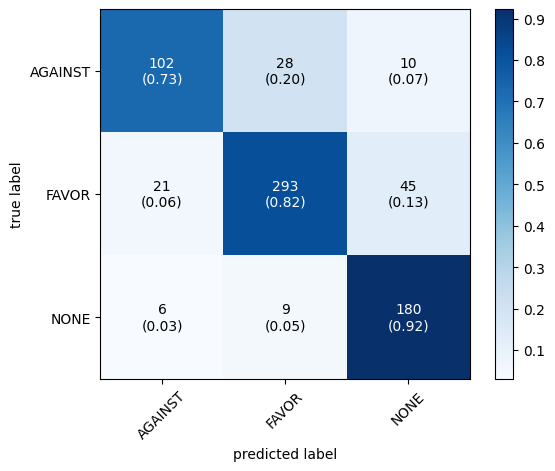

In [ ]:
conf_mat = confusion_matrix(true_labels, predicted_labels)
class_names = ['AGAINST', "FAVOR", "NONE"]

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=class_names)